<a href="https://colab.research.google.com/github/Pperezhogin/pyqg_generative/blob/master/Google-Colab/Copy_of_offline_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Needed only on Google Colab
try:
    import google.colab
    !pip install aiohttp requests zarr pyfftw gcm_filters pyqg cmocean
    !pip install git+https://github.com/m2lines/pyqg_generative.git
    !git clone https://github.com/m2lines/pyqg_generative.git
    !cp -r pyqg_generative/Google-Colab/GAN .
    !cp -r pyqg_generative/Google-Colab/VAE .
    !cp -r pyqg_generative/Google-Colab/GZ .
    print('\n------------- Packages on Google Colab are installed ------------')
except:
    print('\n------------- Not running on Google Colab --------------')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.0/193.0 KB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 41.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 27.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 223.1/223.1 KB 26.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.7/6.7 MB 91.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyqg: filename=pyqg-0.7.2-cp38-cp38-linux_x86_64.whl size=933196 sha256=8d45438553c4968c276b4adcffdfc81306b557e93db0b12be681a5fac48e466e
  Stored in directory: /root/.cache/pip/wheels/a2/e3/ed/02db1e393bf087cc9729ef23e34080ea15cdc6322dbc0aace7
  Created wheel for asciitree: filename=asciitree-0.3.3-py3-no

In [ ]:
import fsspec
import xarray as xr
import matplotlib.pyplot as plt

In [ ]:
def open_zarr(folder):
    for url, label in zip(['https://g-402b19.00888.8540.data.globus.org', 'https://g-771f59.00888.8540.data.globus.org'], ['archive', 'scratch']):
      try:
        mapper = fsspec.get_mapper(f'{url}/{folder}.zarr')
        return xr.open_zarr(mapper, consolidated=True)
      except:
        print(f'{folder} on {label} failed')

In [ ]:
import json
def read_model(folder):
  with open(f'{folder}/model_args.json') as file:
    model_args = json.load(file)
    return eval(model_args.pop('model'))(folder=folder, **model_args)

In [ ]:
ds = open_zarr('eddy/48/sharp')

In [ ]:
test = ds.isel(run=slice(250,252)).load()

# Open pretrained models

In [ ]:
from pyqg_generative.models.cgan_regression import CGANRegression
from pyqg_generative.models.cvae_regression import CVAERegression
from pyqg_generative.models.mean_var_model import MeanVarModel

In [ ]:
gan_model = read_model('GAN')
vae_model = read_model('VAE')
gz_model = read_model('GZ')

reading CGANRegression G, D from GAN
reading CVAERegression from VAE
reading MeanVarModel mean from GZ
reading MeanVarModel var from GZ


# Predict subgrid forcing

In [ ]:
# If you do not have GPU, consider ensembe_size=10
gan = gan_model.test_offline(test, ensemble_size=1000)

In [ ]:
vae = vae_model.test_offline(test, ensemble_size=1000)

In [ ]:
gz = gz_model.test_offline(test)

#Define plot functions of snapshots

In [ ]:
from pyqg_generative.tools.plot_helpers import *

In [ ]:
default_rcParams({'axes.titlelocation': 'center', 'font.size': 16})

/usr/lib/python3.8/_collections_abc.py:832: MatplotlibDeprecationWarning: 
The datapath rcparam was deprecated in Matplotlib 3.2.1 and will be removed two minor releases later.
  self[key] = other[key]
/usr/lib/python3.8/_collections_abc.py:832: MatplotlibDeprecationWarning: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
  self[key] = other[key]
/usr/lib/python3.8/_collections_abc.py:832: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2.
  self[key] = other[key]
/usr/lib/python3.8/_collections_abc.py:832: MatplotlibDeprecationWarning: 
The verbose.fileo rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
  self[key] = other[key]
/usr/lib/python3.8/_collections_abc.py:832: MatplotlibDeprecationWarning: 
The verbose.level rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
  self[key] = other[key]


In [ ]:
sel = lambda x: x.isel(run=1, time=-1, lev=0)

In [ ]:
import cmocean
def plot_q(ds):
  imshow(sel(ds.q), vmax=3, cmap=cmocean.cm.balance, normalize='True', cbar_label='RMS units')
  plt.title('Potential vorticity, $\overline{q}$')
def plot_S(ds):
  imshow(sel(ds.q_forcing_advection), vmax=3, cmap='bwr', normalize='True', cbar_label='RMS units')  
  plt.title('Subgrid forcing, $S$')
def plot_S_sample(ds):
  imshow(sel(ds.q_forcing_advection_gen), vmax=3, cmap='bwr', normalize='True', cbar_label='RMS units')
  plt.title('Sample of subgrid forcing $\widetilde{S}$')
def plot_S_mean(ds):
  imshow(sel(ds.q_forcing_advection_mean), vmax=3, cmap='bwr', normalize='True', cbar_label='RMS units')
  plt.title('Conditional mean $E(\widetilde{S}|\overline{q})$')
def plot_S_std(ds):
  imshow(sel(ds.q_forcing_advection_std), vmax=2, cmap=cmocean.cm.balance, normalize='True', cbar_label='RMS units')
  plt.title('Conditional $Std(\widetilde{S}|\overline{q})$')
def plot_true_residual(ds):
  imshow(sel(ds.q_forcing_advection_res), vmax=3, cmap='viridis', normalize='True', cbar_label='RMS units')
  plt.title('True residual $S-E(\widetilde{S}|\overline{q})$')
def plot_fake_residual(ds):
  imshow(sel(ds.q_forcing_advection_gen_res), vmax=3, cmap='viridis', normalize='True', cbar_label='RMS units')  
  plt.title('Generated residual $\widetilde{S}-E(\widetilde{S}|\overline{q})$')

In [ ]:
def plot_prediction(ds):
  plt.figure(figsize=(12,12))
  fun = [plot_q, plot_S, plot_S_sample, plot_S_mean, plot_S_std, plot_true_residual, plot_fake_residual]
  for j in range(7):
    plt.subplot(3,3,j+1)
    fun[j](ds)

# Snapshots

Text(0.5, 0.95, 'GAN model')

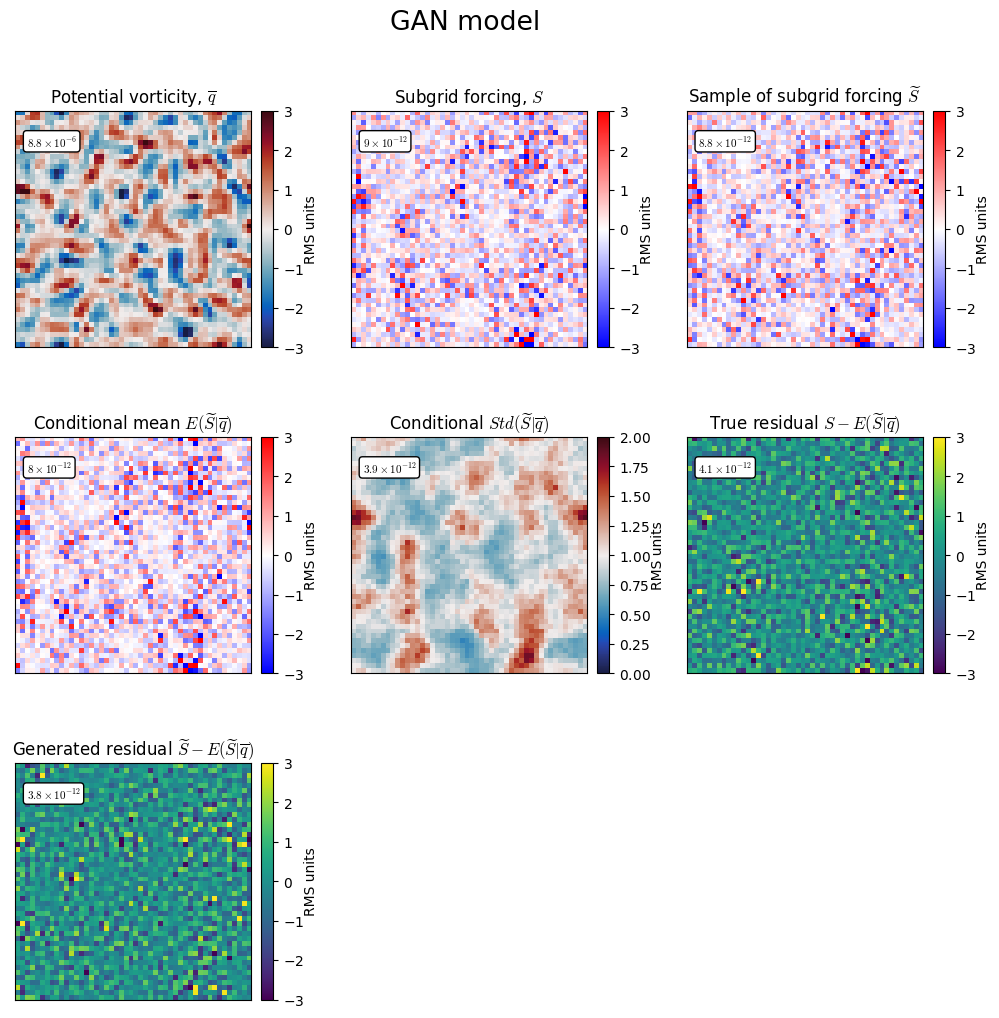

In [ ]:
plot_prediction(gan)
plt.suptitle('GAN model', y=0.95)

Text(0.5, 0.95, 'VAE model')

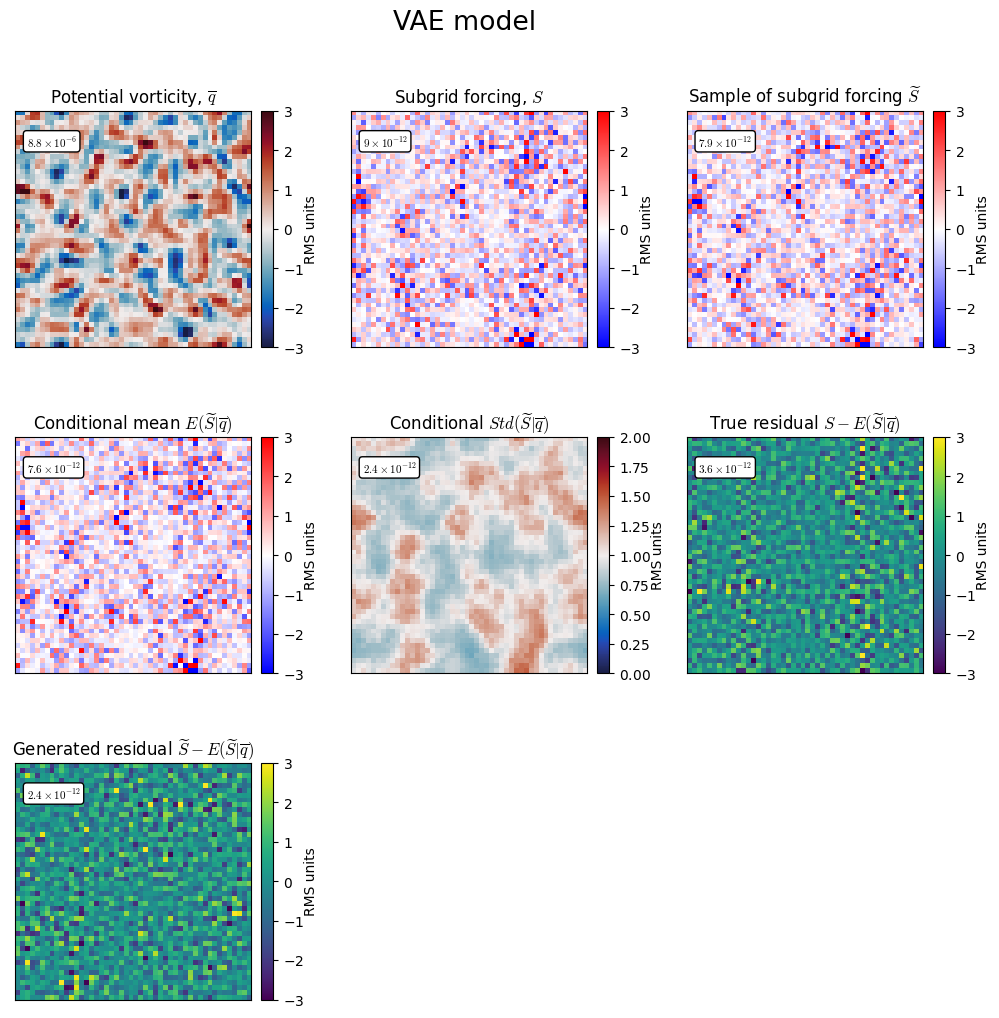

In [ ]:
plot_prediction(vae)
plt.suptitle('VAE model', y=0.95)

Text(0.5, 0.95, 'GZ model')

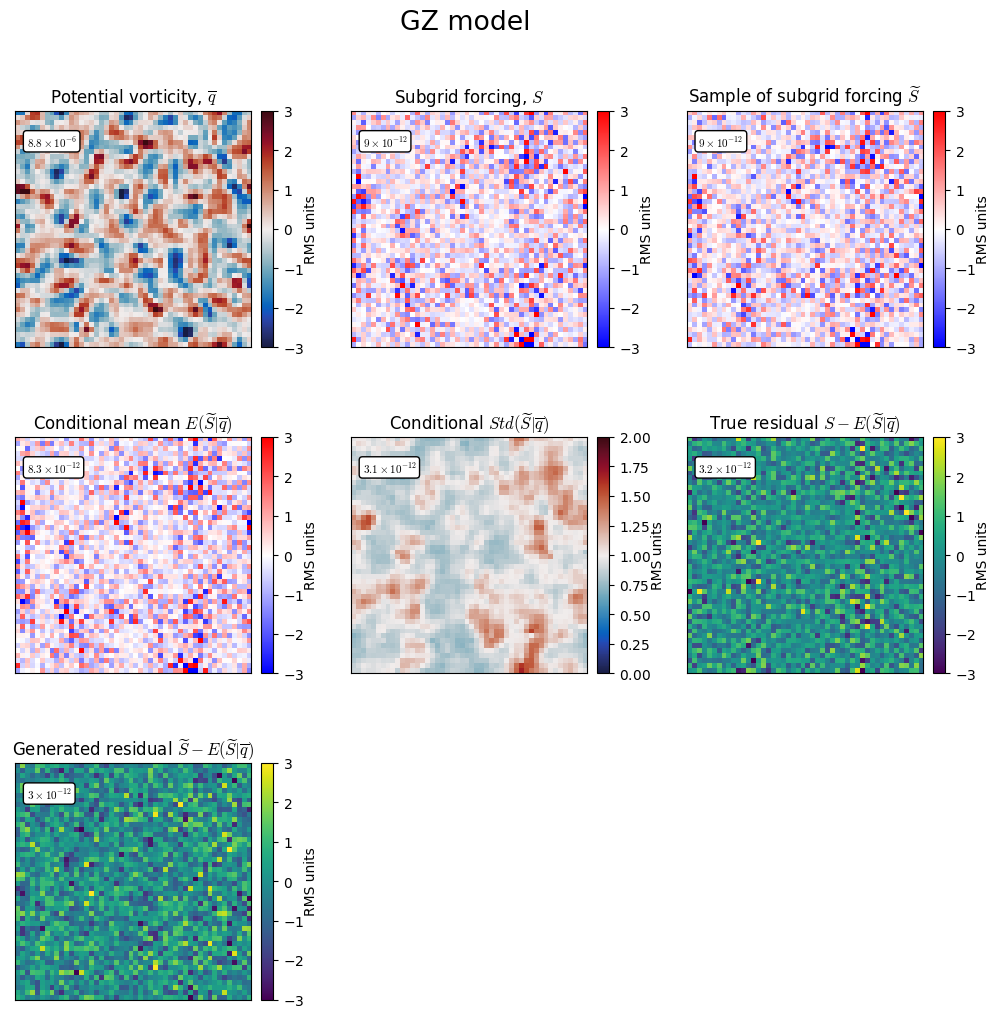

In [ ]:
plot_prediction(gz)
plt.suptitle('GZ model', y=0.95)

# Spectra

Text(0.5, 1.0, '')

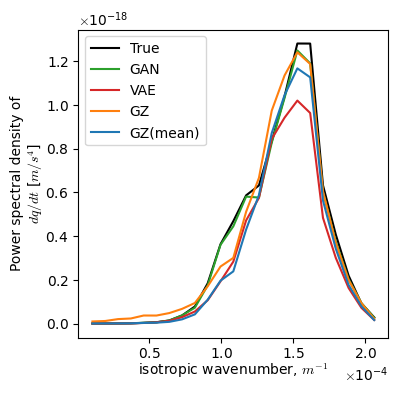

In [ ]:
gan.PSD.isel(lev=0).plot(color='k', label='True')
gan.PSD_gen.isel(lev=0).plot(color='tab:green', label='GAN')
vae.PSD_gen.isel(lev=0).plot(color='tab:red', label='VAE')
gz.PSD_gen.isel(lev=0).plot(color='tab:orange', label='GZ')
gz.PSD_mean.isel(lev=0).plot(color='tab:blue', label='GZ(mean)')
plt.legend()
plt.title('')

# Offline metrics

In [ ]:
from pyqg_generative.tools.computational_tools import subgrid_scores

In [ ]:
def offline_metrics(ds):
  metrics = subgrid_scores(ds.q_forcing_advection, # True
                 ds.q_forcing_advection_mean,      # Conditional mean
                 ds.q_forcing_advection_gen        # One generated sample of subgrid forcing
  )
  print('Deterministic RMSE', metrics['L2_mean'].values)
  print('Spectral RMSE', metrics['L2_total'].values)
  print('Residual RMSE', metrics['L2_residual'].values)
  print('Spread', metrics['var_ratio'].mean().values)
  return metrics

In [ ]:
offline_metrics(gan);

Deterministic RMSE 0.46184033155441284
Spectral RMSE 0.06294532194827125
Residual RMSE 0.18853315029762688
Spread 0.8986635


In [ ]:
offline_metrics(vae);

Deterministic RMSE 0.33586910367012024
Spectral RMSE 0.1662856531487818
Residual RMSE 0.6100610325995228
Spread 0.39741874


In [ ]:
offline_metrics(gz);

Deterministic RMSE 0.30553340911865234
Spectral RMSE 0.10004083600607486
Residual RMSE 0.5773028112953991
Spread 0.99088895
